# NYC bike crash EDA and summary stats

some code to explore the data in the NYC motor vehicle crash data set
data was downloaded from a query from here: 
https://data.cityofnewyork.us/Public-Safety/Motor-Vehicle-Collisions-Crashes/h9gi-nx95/data

the query parameters I used were:

column, condition, value

NUMBER OF CYCLIST INJURED, is at least, 1

NUMBER OF CYCLIST KILLED,  is at least, 1

VEHICLE TYPE CODE (1 - 5), contains, bike or bicycle

"motorbike" was sometimes returned as a match in VEHICLE TYPE


Each condition was "or'ed" with the others.  In other words, only one condition had to be true to return a row.

More data about the people in the collisions might be gotten here:
https://data.cityofnewyork.us/Public-Safety/Motor-Vehicle-Collisions-Person/f55k-p6yu/data

More data about the vehicles in the collisions might be gotten here:
https://data.cityofnewyork.us/Public-Safety/Motor-Vehicle-Collisions-Vehicles/bm4k-52h4/data

The columns are described here:  MVCollisionsDataDictionary_20190813_ERD.xlsx

In [1]:
# the usual
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

# my utilities
from crash_utils.zip_code_and_borough_from_coords import zip_code_and_borough_from_coords
from crash_utils.fix_vehicle_names import fix_vehicle_names
from crash_utils.make_crash_features import make_crash_features
from crash_utils.basic_cleaning import basic_cleaning

In [2]:
data_path = "/Users/Mark/brainstation/capstone/nyc_bike_crash_analysis/data/"
data_file_with_path = data_path + "Motor_Vehicle_Collisions_-_Crashes.csv"
df = pd.read_csv(data_file_with_path)

In [3]:
# fill in missing zip coded and boroughs using lat/lon
df = zip_code_and_borough_from_coords(df)

In [4]:
# perform some basic data munging operations (see `crash_utils/basic_cleaning.py` for details)
df = basic_cleaning(df)

In [5]:
## clean up the VEHICLE TYPE CODE columns
df = fix_vehicle_names(df)

In [7]:
# add some features for easier analysis
df = make_crash_features(df, drop_featured_columns = False)

In [20]:
# now encode the outcome: 0 = no injury, 1 = injury, 2 = fatality

# initiate column
df["outcome"] = np.nan

# no injuries
mask = df["NUMBER OF CYCLIST INJURED"] == 0
df.loc[mask,"outcome"] = 0

# injuries only
mask = df["NUMBER OF CYCLIST INJURED"] > 0
df.loc[mask,"outcome"] = 1

# fatalities
mask = df["NUMBER OF CYCLIST KILLED"] > 0
df.loc[mask,"outcome"] = 2


In [11]:
#df.head()
df.columns

Index(['DATETIME', 'BOROUGH', 'ZIP CODE', 'LATITUDE', 'is_intersection',
       'LONGITUDE', 'ON STREET NAME', 'CROSS STREET NAME',
       'NUMBER OF CYCLIST INJURED', 'NUMBER OF CYCLIST KILLED',
       'CONTRIBUTING FACTOR VEHICLE 1', 'CONTRIBUTING FACTOR VEHICLE 2',
       'CONTRIBUTING FACTOR VEHICLE 3', 'CONTRIBUTING FACTOR VEHICLE 4',
       'CONTRIBUTING FACTOR VEHICLE 5', 'COLLISION_ID', 'VEHICLE TYPE CODE 1',
       'VEHICLE TYPE CODE 2', 'VEHICLE TYPE CODE 3', 'VEHICLE TYPE CODE 4',
       'VEHICLE TYPE CODE 5', 'MONTH', 'DAY_OF_WEEK', 'HOUR', 'n_vehicle',
       'VEHICLES', 'n_factor', 'factors'],
      dtype='object')

In [15]:
# remove COLLISION_ID is not cross-referencing with other data files (e.g. - )
df.drop(columns="COLLISION_ID", inplace = True)

In [16]:
print(df["DATETIME"].min())
print(df["DATETIME"].max())

2012-07-01 00:20:00
2020-11-14 22:08:00


In [17]:
# write a clean data file for use with Tableau
# df.to_csv("data/cleaned_nyc_crash_table.csv", index = False)

# Summary statistics

## some basic numbers

In [18]:
df.shape

(47468, 28)

In [22]:
df["outcome"].value_counts().sort_index()

0.0    10896
1.0    36422
2.0      150
Name: outcome, dtype: int64

In [25]:
df["NUMBER OF CYCLIST INJURED"].value_counts().sort_values(ascending = False)

1    36096
0    11041
2      321
3        9
4        1
Name: NUMBER OF CYCLIST INJURED, dtype: int64

In [27]:
df["NUMBER OF CYCLIST KILLED"].value_counts().sort_values(ascending = False)

0    47318
1      149
2        1
Name: NUMBER OF CYCLIST KILLED, dtype: int64

## make a nice map showing accidents

https://towardsdatascience.com/visualizing-geospatial-data-in-python-e070374fe621

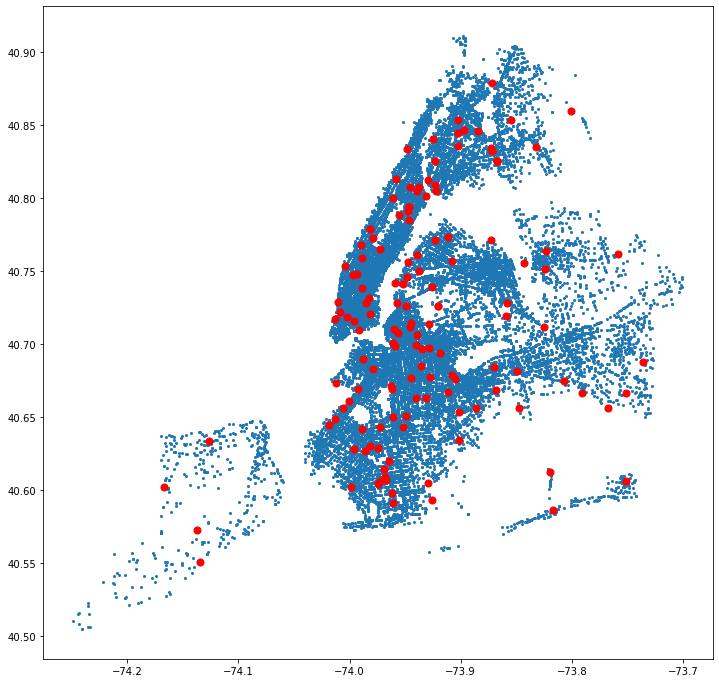

In [34]:
plt.figure(figsize=(12,12));

mask = df["NUMBER OF CYCLIST INJURED"] >0
plt.scatter(df.loc[mask,"LONGITUDE"],df.loc[mask,"LATITUDE"],4);

# mask = df["NUMBER OF CYCLIST INJURED"] == 0
# plt.scatter(df.loc[mask,"LONGITUDE"],df.loc[mask,"LATITUDE"],3,'black',alpha = 0.3);

mask = df["NUMBER OF CYCLIST KILLED"] >0
plt.scatter(df.loc[mask,"LONGITUDE"],df.loc[mask,"LATITUDE"],50,"red");

plt.show()

In [45]:
# breakdown by borough
df.groupby(by="BOROUGH").sum()[["NUMBER OF CYCLIST KILLED","NUMBER OF CYCLIST INJURED"]].sort_values(by = "NUMBER OF CYCLIST INJURED", ascending=False)
#df.groupby(by=["BOROUGH","outcome"]).sum()[["NUMBER OF CYCLIST INJURED"]]

,NUMBER OF CYCLIST KILLED,NUMBER OF CYCLIST INJURED
BOROUGH,,
BROOKLYN,61,14487
MANHATTAN,39,10937
QUEENS,32,7125
BRONX,15,3729
STATEN ISLAND,4,491


In [46]:
# streets with the most fatalities
df.groupby("ON STREET NAME").sum()["NUMBER OF CYCLIST KILLED"].sort_values(ascending=False).head(10)

ON STREET NAME
OTHER                 30
UNKNOWN                7
3 AVENUE               5
BRUCKNER BOULEVARD     3
PARK AVENUE            3
WEST STREET            3
1 AVENUE               2
ROCKAWAY BOULEVARD     2
GRAND CONCOURSE        2
BROADWAY               2
Name: NUMBER OF CYCLIST KILLED, dtype: int64

In [47]:
# streets with the most injuries
df.groupby("ON STREET NAME").sum()["NUMBER OF CYCLIST INJURED"].sort_values(ascending=False).head(10)

ON STREET NAME
UNKNOWN             4835
OTHER               4587
BROADWAY             843
5 AVENUE             479
BEDFORD AVENUE       416
2 AVENUE             370
3 AVENUE             362
1 AVENUE             315
FULTON STREET        271
ROOSEVELT AVENUE     268
Name: NUMBER OF CYCLIST INJURED, dtype: int64

In [60]:
#df.head()

In [59]:
df["VEHICLES"].value_counts().head(20)

passenger-vehicle bike                        26954
bike                                           4083
bike passenger-vehicle                         3780
taxi bike                                      3526
unknown bike                                   1267
van bike                                        659
pick-up-truck bike                              567
passenger-vehicle e-bike                        523
bus bike                                        497
passenger-vehicle e-scooter                     426
bike taxi                                       419
limousine bike                                  401
large-com-veh bike                              343
other bike                                      309
passenger-vehicle bike passenger-vehicle        283
bike bike                                       252
small-com-veh bike                              195
passenger-vehicle passenger-vehicle bike        167
bike unknown                                    166
e-bike      

In [68]:
df.groupby("VEHICLES").sum()[["NUMBER OF CYCLIST INJURED","NUMBER OF CYCLIST KILLED"]].sort_values(by="NUMBER OF CYCLIST KILLED", ascending = False).head(30)

,NUMBER OF CYCLIST INJURED,NUMBER OF CYCLIST KILLED
VEHICLES,,
passenger-vehicle bike,21352,46
large-com-veh bike,261,14
bus bike,373,8
unknown bike,1058,7
tractor-truck bike,20,7
bike passenger-vehicle,2955,6
taxi bike,2612,5
pick-up-truck bike,452,4
passenger-vehicle passenger-vehicle bike,124,4


In [69]:
df.groupby("factors").sum()[["NUMBER OF CYCLIST INJURED","NUMBER OF CYCLIST KILLED"]].sort_values(by="NUMBER OF CYCLIST KILLED", ascending = False).head(30)

,NUMBER OF CYCLIST INJURED,NUMBER OF CYCLIST KILLED
factors,,
Unspecified Unspecified,9497,29
Pedestrian/Bicyclist/Other-Pedestrian-Error/Confusion Unspecified,1337,17
Driver-Inattention Unspecified,5292,14
Traffic-Control-Disregarded Unspecified,1192,9
Failure-to-Yield-Right-of-Way Unspecified,3282,8
Driver-Inattention Unspecified Unspecified,130,6
Unspecified Unspecified Unspecified,220,5
Unspecified,1209,4
Alcohol-Involvement Unspecified,204,4


## time series!

In [70]:
df.head()

,DATETIME,BOROUGH,ZIP CODE,LATITUDE,is_intersection,LONGITUDE,ON STREET NAME,CROSS STREET NAME,NUMBER OF CYCLIST INJURED,NUMBER OF CYCLIST KILLED,...,VEHICLE TYPE CODE 4,VEHICLE TYPE CODE 5,MONTH,DAY_OF_WEEK,HOUR,n_vehicle,VEHICLES,n_factor,factors,outcome
0,2012-07-01 00:20:00,BROOKLYN,11215.0,40.677406,True,-73.983048,4 AVENUE,UNION STREET,0,0,...,,,7,6,0,2,unknown bike,2,Prescription-Medication Unspecified,0.0
1,2012-07-01 02:30:00,MANHATTAN,10065.0,40.764162,True,-73.968890,EAST 61 STREET,PARK AVENUE,1,0,...,,,7,6,2,2,taxi bike,2,Other-Vehicular Passenger-Distraction,1.0
2,2012-07-01 06:50:00,BRONX,10468.0,40.862679,True,-73.909040,SEDGWICK AVENUE,WEST FORDHAM ROAD,1,0,...,,,7,6,6,2,passenger-vehicle bike,2,Driver-Inattention Unspecified,1.0
3,2012-07-01 07:30:00,BROOKLYN,11218.0,40.633745,True,-73.972283,OCEAN PARKWAY,AVENUE F,0,0,...,,,7,6,7,2,passenger-vehicle bike,2,Unspecified Unspecified,0.0
4,2012-07-01 12:15:00,BROOKLYN,11211.0,40.711801,True,-73.942229,GRAND STREET,HUMBOLDT STREET,1,0,...,,,7,6,12,2,passenger-vehicle bike,2,Unspecified Unspecified,1.0


In [72]:
# hey let's plot a time series!
df.resample('M',on="DATETIME",loffset="-15D").sum()["NUMBER OF CYCLIST INJURED"]

DATETIME
2012-07-16    417
2012-08-16    459
2012-09-15    395
2012-10-16    297
2012-11-15    256
             ... 
2020-07-16    691
2020-08-16    716
2020-09-15    705
2020-10-16    603
2020-11-15    257
Name: NUMBER OF CYCLIST INJURED, Length: 101, dtype: int64

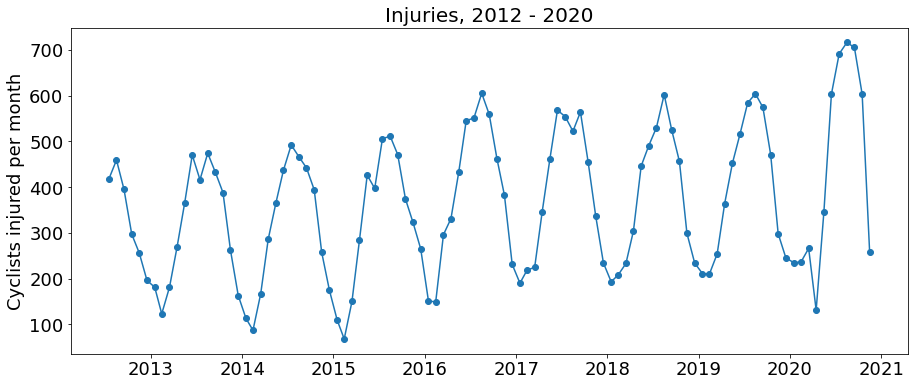

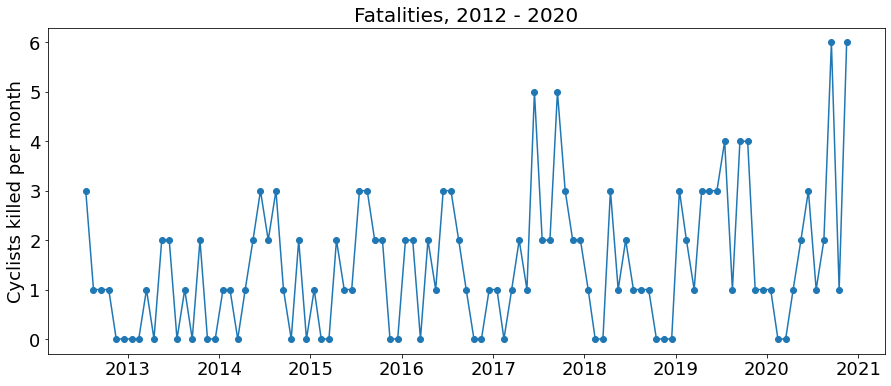

In [74]:
plt.figure(figsize=(15,6))
plt.plot(df.resample('M',on="DATETIME",loffset="-15D").sum()["NUMBER OF CYCLIST INJURED"],marker='o')
plt.ylabel("Cyclists injured per month", size = 18);
plt.xticks(fontsize=18);
plt.yticks(fontsize=18);
plt.title("Injuries, 2012 - 2020", size = 20);
plt.show()

plt.figure(figsize=(15,6))
plt.plot(df.resample('M',on="DATETIME",loffset="-15D").sum()["NUMBER OF CYCLIST KILLED"],marker='o')
plt.ylabel("Cyclists killed per month", size = 18);
plt.xticks(fontsize=18);
plt.yticks(fontsize=18);
plt.title("Fatalities, 2012 - 2020", size = 20);
plt.show()

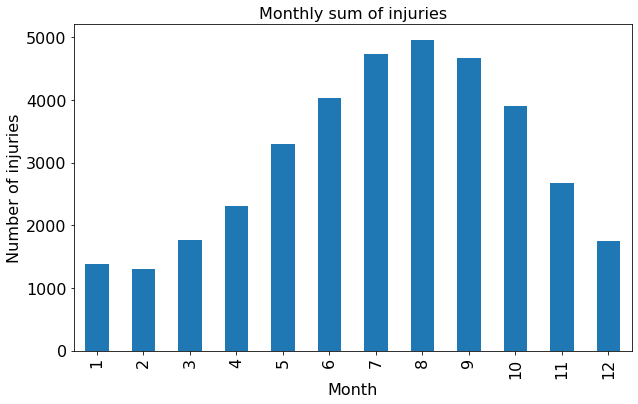

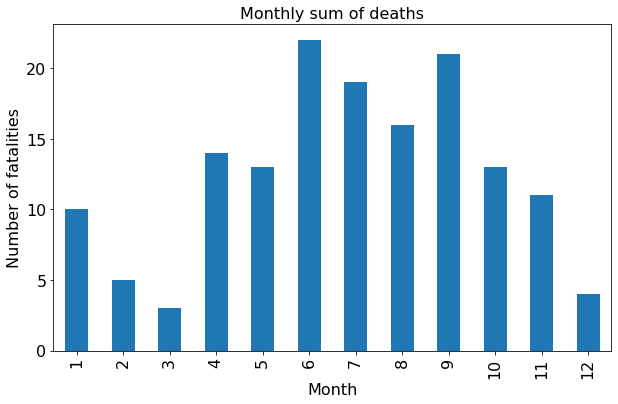

In [82]:
plt.figure()
df.groupby("MONTH").sum()["NUMBER OF CYCLIST INJURED"].plot.bar(figsize=(10,6));
plt.title("Monthly sum of injuries", size = 16)
plt.ylabel("Number of injuries", size = 16);
plt.xlabel("Month", size=16)
plt.xticks(size=16)
plt.yticks(size=16)
plt.show()

plt.figure()
df.groupby("MONTH").sum()["NUMBER OF CYCLIST KILLED"].plot.bar(figsize=(10,6));
plt.title("Monthly sum of deaths", size = 16)
plt.ylabel("Number of fatalities", size = 16);
plt.xlabel("Month", size=16)
plt.xticks(size=16)
plt.yticks(size=16)
plt.show()

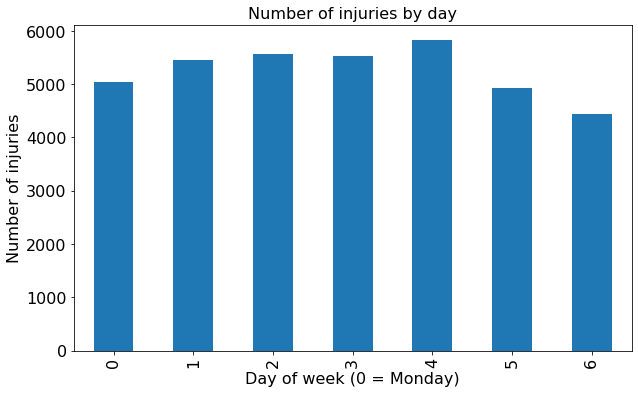

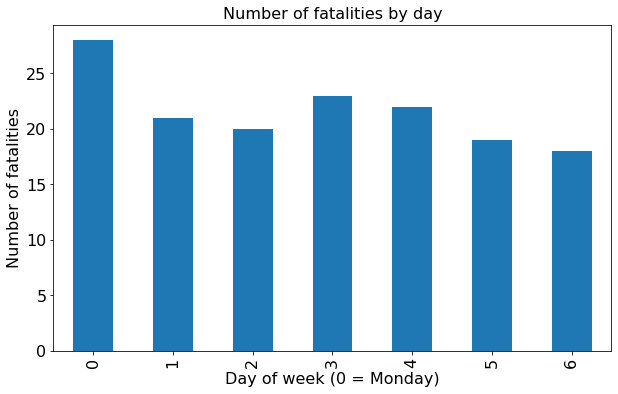

In [86]:
# Monday is day 0
plt.figure()
df.groupby("DAY_OF_WEEK").sum()["NUMBER OF CYCLIST INJURED"].plot.bar(figsize=(10,6));
plt.title("Number of injuries by day", size = 16)
plt.xlabel("Day of week (0 = Monday)", size = 16);
plt.ylabel("Number of injuries", size = 16);
plt.xticks(size=16);
plt.yticks(size=16);
plt.show()

plt.figure()
df.groupby("DAY_OF_WEEK").sum()["NUMBER OF CYCLIST KILLED"].plot.bar(figsize=(10,6));
plt.title("Number of fatalities by day", size = 16)
plt.xlabel("Day of week (0 = Monday)", size = 16);
plt.ylabel("Number of fatalities", size = 16);
plt.xticks(size=16);
plt.yticks(size=16);
plt.show()

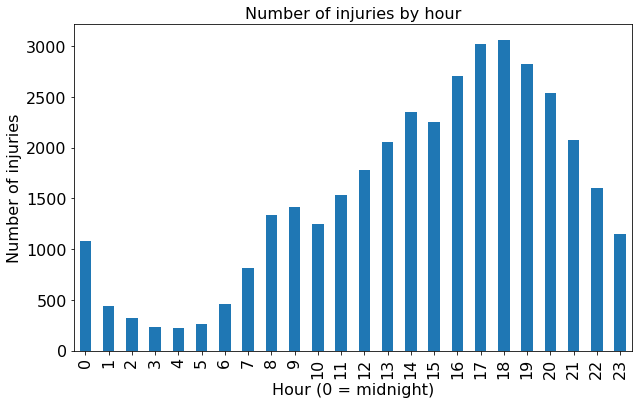

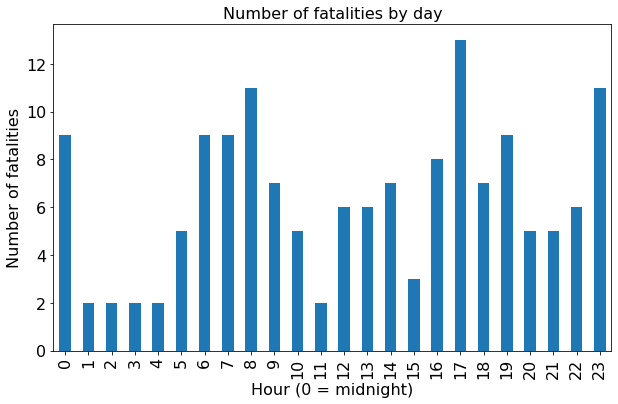

In [91]:
# Hour of day
plt.figure()
df.groupby("HOUR").sum()["NUMBER OF CYCLIST INJURED"].plot.bar(figsize=(10,6));
plt.title("Number of injuries by hour", size = 16)
plt.xlabel("Hour (0 = midnight)", size = 16);
plt.ylabel("Number of injuries", size = 16);
plt.xticks(size=16);
plt.yticks(size=16);
plt.show()

plt.figure()
df.groupby("HOUR").sum()["NUMBER OF CYCLIST KILLED"].plot.bar(figsize=(10,6));
plt.title("Number of fatalities by day", size = 16)
plt.xlabel("Hour (0 = midnight)", size = 16);
plt.ylabel("Number of fatalities", size = 16);
plt.xticks(size=16);
plt.yticks(size=16);
plt.show()

In [90]:
df.columns

Index(['DATETIME', 'BOROUGH', 'ZIP CODE', 'LATITUDE', 'is_intersection',
       'LONGITUDE', 'ON STREET NAME', 'CROSS STREET NAME',
       'NUMBER OF CYCLIST INJURED', 'NUMBER OF CYCLIST KILLED',
       'CONTRIBUTING FACTOR VEHICLE 1', 'CONTRIBUTING FACTOR VEHICLE 2',
       'CONTRIBUTING FACTOR VEHICLE 3', 'CONTRIBUTING FACTOR VEHICLE 4',
       'CONTRIBUTING FACTOR VEHICLE 5', 'VEHICLE TYPE CODE 1',
       'VEHICLE TYPE CODE 2', 'VEHICLE TYPE CODE 3', 'VEHICLE TYPE CODE 4',
       'VEHICLE TYPE CODE 5', 'MONTH', 'DAY_OF_WEEK', 'HOUR', 'n_vehicle',
       'VEHICLES', 'n_factor', 'factors', 'outcome'],
      dtype='object')